In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, Resized, EnsureTyped, Lambdad, AsDiscrete
)
from monai.data import (decollate_batch, Dataset)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt
import sys
import logging
from monai.utils import set_determinism
import os
from glob import glob
from PIL import Image

# Set logging and configuration
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Set determinism for reproducibility
set_determinism(seed=0)

# Data loading and transformations
data_transform = Compose([
    LoadImaged(keys=["img", "seg"], reader="PILReader"),  # Use PILReader explicitly for TIFF files
    EnsureChannelFirstd(keys=["img", "seg"]),
    ScaleIntensityd(keys=["img"]),
    Lambdad(keys="seg", func=lambda x: (x.long() % 13) if isinstance(x, torch.Tensor) else (torch.from_numpy(x).long() % 13)),  # Ensure labels are in the range 0-12
    Resized(keys=["img", "seg"], spatial_size=(256, 256)),
    EnsureTyped(keys=["img", "seg"]),
])

# Define paths to images and masks
# data_dir = "Rabbit AI - Thorax & Abdomen/ground_truth"
data_dir = "Rabbit AI - New/ground_truth"
image_files = sorted(glob(os.path.join(data_dir, "images", "*.tif")))
mask_files = sorted(glob(os.path.join(data_dir, "masks", "*.tif")))



# Define directories
images_dir = 'Rabbit AI - New/ground_truth/images'
masks_dir = 'Rabbit AI - New/ground_truth/masks'
output_images_dir = 'Augmented/images'
output_masks_dir = 'Augmented/masks'

# Create output directories if they don't exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

# Create lists of image and mask files
images = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith('.tif')])
masks = sorted([os.path.join(masks_dir, mask) for mask in os.listdir(masks_dir) if mask.endswith('.tif')])

# Print number of images and masks found before transformation
print(f"Found {len(images)} images and {len(masks)} masks before transformation")

# Function to apply augmentations and save
def augment_and_save(data_files, num_augmentations, output_img_dir, output_mask_dir):
    augmented_count = 0
    for i, data in enumerate(data_files):
        #print(f"Original mask labels for sample {i}: {np.unique(Image.open(data['seg']))}")
        for j in range(num_augmentations):
            sample = data_transform(data)
            img, seg = sample['img'], sample['seg']
            img_np = img.numpy().squeeze()
            seg_np = seg.numpy().squeeze()
            #print(f"Augmented mask labels for sample {i}, augmentation {j}: {np.unique(seg_np)}")
            img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
            seg_pil = Image.fromarray((seg_np * 255).astype(np.uint8))
            img_pil.save(os.path.join(output_img_dir, f'aug_{i}_{j}.tif'))
            seg_pil.save(os.path.join(output_mask_dir, f'aug_{i}_{j}.tif'))
            augmented_count += 1
    return augmented_count

# Prepare dataset
data_files = [{"img": img, "seg": mask} for img, mask in zip(images, masks)]

# Number of augmentations per original sample
num_augmentations = 5

# Augment and save the dataset
augmented_count = augment_and_save(data_files, num_augmentations, output_images_dir, output_masks_dir)

# Print out the result
print(f"Number of original samples: {len(data_files)}")
print(f"Number of augmented samples generated: {augmented_count}")
print(f"Total number of samples after augmentation: {len(data_files) * num_augmentations}")

# Prepare lists of augmented image and mask files
images = sorted([os.path.join(output_images_dir, img) for img in os.listdir(output_images_dir) if img.endswith('.tif')])
masks = sorted([os.path.join(output_masks_dir, mask) for mask in os.listdir(output_masks_dir) if mask.endswith('.tif')])

# Print number of images and masks found
print(f"Found {len(images)} images and {len(masks)} masks")


# Ensure that the number of images and masks are the same
assert len(images) == len(masks), "Number of images and masks must be the same"

# Create the train and validation file lists
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:25], masks[:25])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[25:], masks[25:])]

# Print out some paths to verify
print(train_files[:2])
print(val_files[:2])



train_ds = Dataset(data=train_files, transform=data_transform)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

val_ds = Dataset(data=val_files, transform=data_transform)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.3.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Users/<username>/miniconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.23.2
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.15.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For detail

Epoch 1/50
Labels shape: torch.Size([4, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Labels shape: torch.Size([4, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Labels shape: torch.Size([4, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Labels shape: torch.Size([4, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Labels shape: torch.Size([4, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Labels shape: torch.Size([4, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Labels shape: torch.Size([1, 1, 256, 256]), unique values: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Epoch 1 average loss: 0.9573
Epoch 2/50
Labels shape: torc

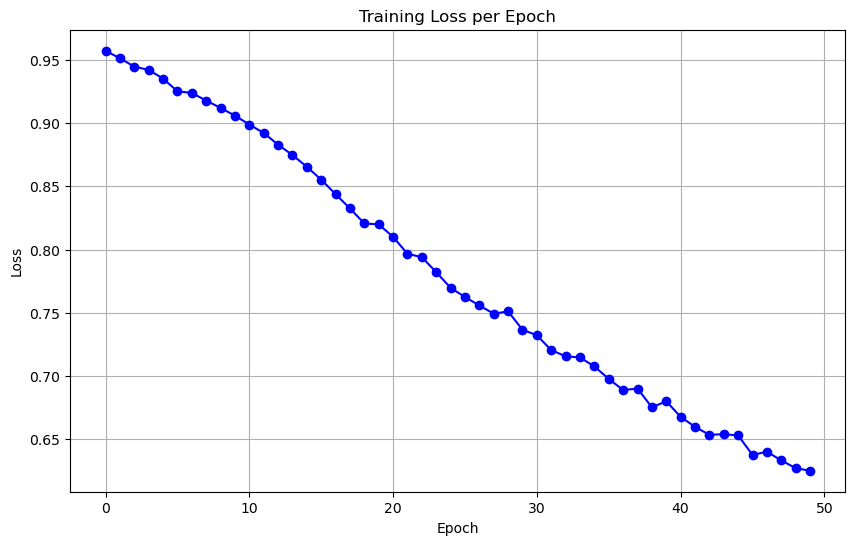

In [2]:

# Model definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,  # Updated argument name
    in_channels=1,
    out_channels=13,  # Ensure the model is defined to output 13 classes
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)  # Ensure softmax is used for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

# Training loop
max_epochs = 50
epoch_losses = []
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

def visualize_predictions(images, true_masks, pred_masks, raw_outputs, num_images=3, alpha=0.5):
    for i in range(num_images):
        fig, ax = plt.subplots(1, 3, figsize=(20, 5))
        ax[0].imshow(images[i, 0], cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original Image')
        ax[1].imshow(images[i, 0], cmap='gray')
        ax[1].imshow(true_masks[i, 0], alpha=alpha)
        ax[1].axis('off')
        ax[1].set_title('Ground Truth Mask')
        ax[2].imshow(images[i, 0], cmap='gray')
        ax[2].imshow(pred_masks[i, 0], alpha=alpha)
        ax[2].axis('off')
        ax[2].set_title('Predicted Mask')
        plt.tight_layout()
        plt.show()

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)

        # Debug: Print shape and unique values of labels
        print(f"Labels shape: {labels.shape}, unique values: {torch.unique(labels)}")

        optimizer.zero_grad()
        outputs = model(inputs)

        # Debug: Print shape of outputs
        # print(f"Outputs shape: {outputs.shape}")

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    epoch_losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
                print(val_labels)
                val_outputs = model(val_images)
                val_outputs = torch.softmax(val_outputs, dim=1)  # Ensure softmax for multi-class
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("Saved new best metric model")
            print(f"Current epoch: {epoch + 1} current mean dice: {metric:.4f} best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")

# Plotting the epoch losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


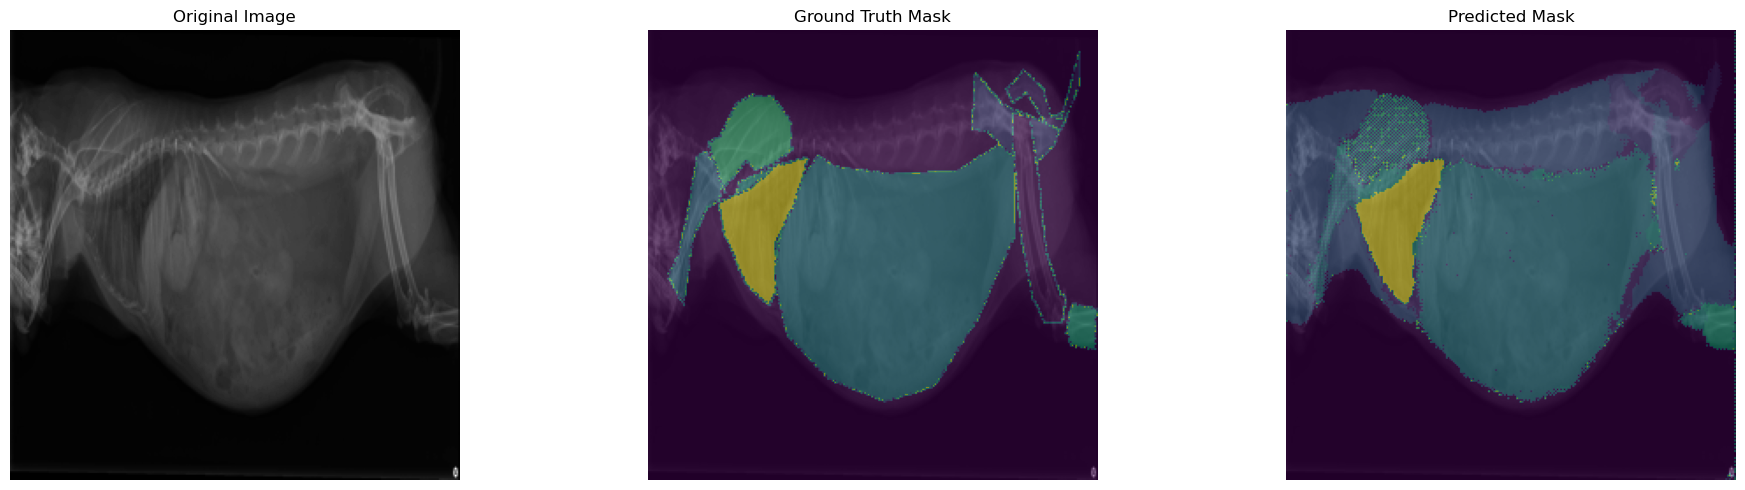

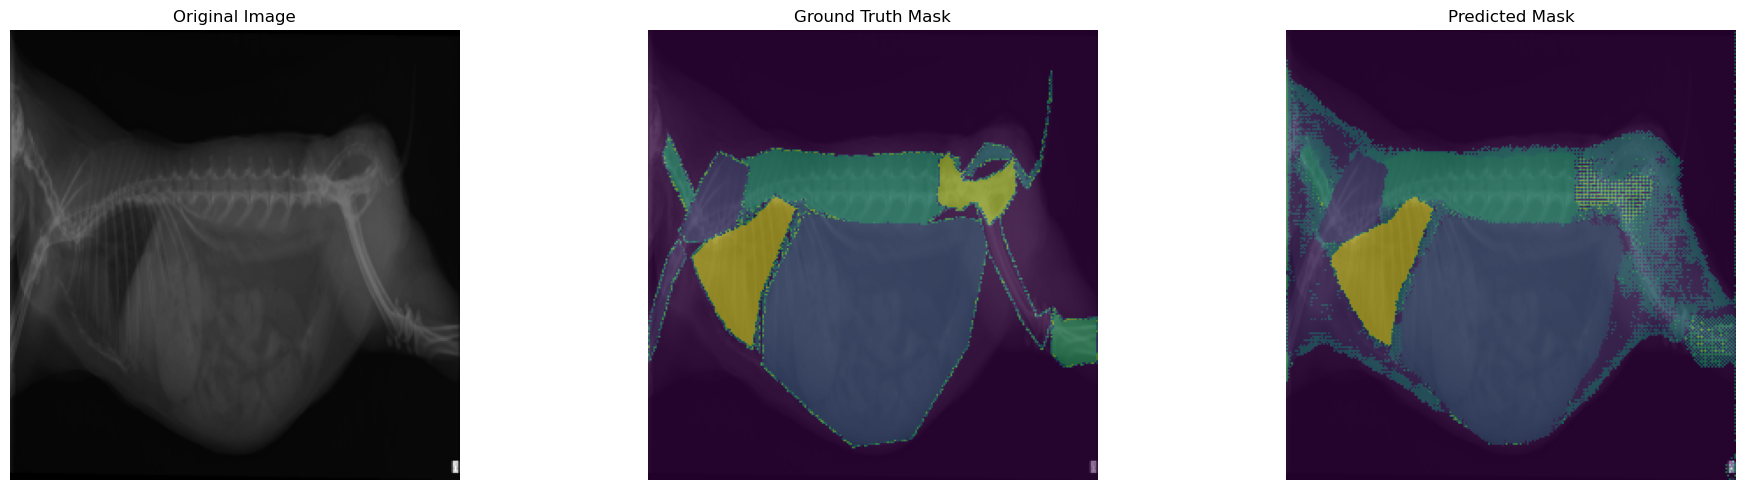

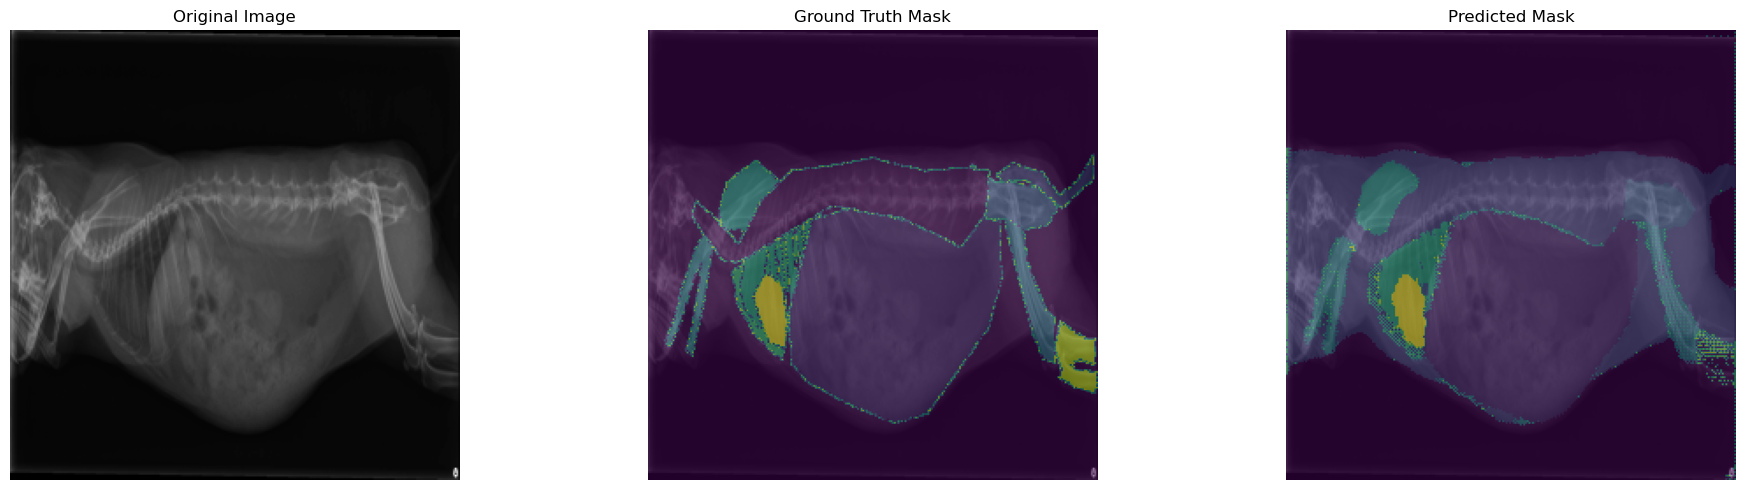

In [7]:
# Evaluate and visualize predictions
model.eval()
with torch.no_grad():
    for batch in train_loader:
        images, true_masks = batch["img"].to(device), batch["seg"].to(device)
        predictions = model(images)
        raw_outputs = torch.softmax(predictions, dim=1)
        predicted_masks = torch.argmax(raw_outputs, dim=1, keepdim=True).float()

        images_np = images.cpu().numpy()
        true_masks_np = true_masks.cpu().numpy()
        predicted_masks_np = predicted_masks.cpu().numpy()
        raw_outputs_np = raw_outputs.cpu().numpy()

        visualize_predictions(images_np, true_masks_np, predicted_masks_np, raw_outputs_np, num_images=3)
        break

In [4]:
# Ensure your model is in evaluation mode
model.eval()

all_predictions = []
all_ground_truths = []

# Perform inference on your test data
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['img'].to(device)  # Adjust to your data format
        labels = batch['seg'].to(device)  # Adjust to your data format
        
        outputs = model(inputs)
        
        # Convert outputs to binary predictions by taking the channel with the highest logit
        preds = torch.argmax(outputs, dim=1, keepdim=True).float()
        
        
        all_predictions.append(preds.cpu())
        all_ground_truths.append(labels.cpu())

# Concatenate all predictions and ground truths
all_predictions = torch.cat(all_predictions)
all_ground_truths = torch.cat(all_ground_truths)

# Print concatenated shapes for debugging
print(f"all_predictions shape: {all_predictions.shape}")
print(f"all_ground_truths shape: {all_ground_truths.shape}")

import torch
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(predictions, ground_truths, num_classes=1):
    if num_classes > 1:
        # For multi-class, convert predictions to class labels
        predictions = torch.argmax(predictions, dim=1, keepdim=True)
    else:
        # For binary, convert predictions to binary masks
        predictions = (predictions > 0.5).float()

    # Flatten the tensors
    predictions = predictions.view(-1)
    ground_truths = ground_truths.view(-1)
    
    ious = []
    dice_scores = []
    
    for cls in range(num_classes):
        pred_cls = (predictions == cls).float()
        gt_cls = (ground_truths == cls).float()

        # Calculate intersection and union
        intersection = torch.sum(pred_cls * gt_cls)
        union = torch.sum(pred_cls) + torch.sum(gt_cls) - intersection
        
        # Avoid division by zero
        union = torch.where(union == 0, torch.tensor(1.0), union)
        
        # Calculate IoU
        iou = intersection / union
        ious.append(iou.item())

        # Calculate Dice score
        dice = (2 * intersection) / (torch.sum(pred_cls) + torch.sum(gt_cls))
        dice_scores.append(dice.item())
    
    # Calculate pixel accuracy
    pixel_accuracy = accuracy_score(ground_truths.cpu().numpy(), predictions.cpu().numpy())
    
    return {
        "pixel_accuracy": pixel_accuracy,
        "mean_dice_score": np.mean(dice_scores),
        "mean_iou": np.mean(ious),
        "ious": ious,  # IoU per class
        "dice_scores": dice_scores  # Dice score per class
    }

# Dummy data for illustration (replace with actual data)
# For binary predictions: (batch_size, 1, height, width)
# For multi-class predictions: (batch_size, num_classes, height, width)
predictions = torch.randn((6, 13, 256, 256))  # Example multi-class prediction tensor
ground_truths = torch.randint(0, 13, (6, 1, 256, 256))  # Example ground truth tensor

# Compute metrics
metrics = compute_metrics(predictions, ground_truths, num_classes=13)

# Print metrics
print(metrics)


all_predictions shape: torch.Size([130, 1, 256, 256])
all_ground_truths shape: torch.Size([130, 1, 256, 256])
{'pixel_accuracy': 0.07704925537109375, 'mean_dice_score': 0.07704402506351471, 'mean_iou': 0.040066228463099554, 'ious': [0.03945566713809967, 0.04015857353806496, 0.03936561569571495, 0.04022929072380066, 0.038143884390592575, 0.03965567424893379, 0.03983459621667862, 0.03909136354923248, 0.04085073992609978, 0.040705516934394836, 0.04052869603037834, 0.041838016360998154, 0.041003335267305374], 'dice_scores': [0.07591601461172104, 0.0772162526845932, 0.07574930787086487, 0.07734696567058563, 0.07348477095365524, 0.07628617435693741, 0.07661718130111694, 0.07524143159389496, 0.07849490642547607, 0.07822677493095398, 0.07790019363164902, 0.08031578361988068, 0.07877656817436218]}


In [5]:
# Ensure your model is in evaluation mode
model.eval()

all_predictions = []
all_ground_truths = []

# Perform inference on your test data
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['img'].to(device)  # Adjust to your data format
        labels = batch['seg'].to(device)  # Adjust to your data format
        
        outputs = model(inputs)
        
        # Convert outputs to binary predictions by taking the channel with the highest logit
        preds = torch.argmax(outputs, dim=1, keepdim=True).float()
        
        
        all_predictions.append(preds.cpu())
        all_ground_truths.append(labels.cpu())

# Concatenate all predictions and ground truths
all_predictions = torch.cat(all_predictions)
all_ground_truths = torch.cat(all_ground_truths)

# Print concatenated shapes for debugging
print(f"all_predictions shape: {all_predictions.shape}")
print(f"all_ground_truths shape: {all_ground_truths.shape}")

def calculate_metrics(predictions, ground_truths):
    # Ensure predictions and ground truths have the same shape
    if predictions.shape != ground_truths.shape:
        raise ValueError("Shape mismatch between predictions and ground truths")
    
    # Initialize DiceMetric
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    
    # Ensure predictions are discrete (binary in this case)
    post_pred = AsDiscrete(threshold=0.5)
    
    # Apply the discrete transformation to the predictions
    predictions = [post_pred(i) for i in decollate_batch(predictions)]
    ground_truths = decollate_batch(ground_truths)
    
    # Compute Dice score
    dice_metric(y_pred=predictions, y=ground_truths)
    dice_score = dice_metric.aggregate().item()
    
    # Clear the metric state
    dice_metric.reset()
    
    # Flatten the tensors to calculate pixel accuracy
    predictions_flat = torch.cat([i.view(-1) for i in predictions])
    ground_truths_flat = torch.cat([i.view(-1) for i in ground_truths])
    
    # Calculate pixel accuracy
    pixel_accuracy = torch.mean((predictions_flat == ground_truths_flat).float()).item()
    
    # Calculate IoU
    intersection = (predictions_flat * ground_truths_flat).sum().item()
    union = predictions_flat.sum().item() + ground_truths_flat.sum().item() - intersection
    iou = intersection / union if union != 0 else 0.0
    
    return {
        "pixel_accuracy": pixel_accuracy,
        "dice_score": dice_score,
        "iou": iou
    }

# Calculate metrics
metrics = calculate_metrics(all_predictions, all_ground_truths)
print(metrics)

all_predictions shape: torch.Size([130, 1, 256, 256])
all_ground_truths shape: torch.Size([130, 1, 256, 256])
{'pixel_accuracy': 0.4680715799331665, 'dice_score': 0.11293213069438934, 'iou': 3.4351456997093943}
